# Figure 3
Create a figure showing 1) scatter plot dEPT/dSO vs. swcf, 2) scatter plot Clim ITCZ vs. swcf, and 3) map of SWCF vs dEPT/dSO

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
from typing import Tuple

# Plotting Utils

In [2]:
def create_panel_a(ax, x6, y6, x5: list = [], y5: list = [], vline=0) -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        ax.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP5_label)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP6_label = f"r={r}"
    
    ax.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)

    # Multimodel mean
    mmm = np.mean([*x5, *x6])


    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))

    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    if p < .05: 
        sig = '*'
    else: 
        sig = ''
    print(r, p)

    x = np.array(sorted(x))
    ax.plot(x, x*slope+intercept, color="black")
    # ax.legend(loc="upper left", fontsize=fontsize)
    ax.set_title(f"r={r}{sig}", loc="right", fontweight="bold", fontsize=16)
    
    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    ax.set_xlim(xmin-borderx, xmax+borderx)
    ax.set_ylim(ymin-bordery, ymax+bordery)

    # Vertical line for avg and std of obs
    ax.vlines(np.mean(vline), ymin=ymin-bordery, ymax=ymax+bordery, color="navy")
    ax.fill_between(x=[np.mean(vline) - np.std(vline), np.mean(vline) + np.std(vline)], y1=ymin-bordery, y2=ymax+bordery,color="navy", alpha=.25)

    # Add Model Vertical Lines
    ax.vlines(mmm, ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], label='_nolegend_', alpha=.5, linewidth=2, zorder=0) 
    # ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=-1, y2=2.5, color="black", alpha=.25)
    ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=np.min(y)*5-50, y2=np.max(y)*5+50, color="black", alpha=.25)

    # Add horizontal sigma lines
    sig_mmm = mmm*slope+intercept
    sig_obs = np.mean(vline)*slope+intercept
    hline_width = 3
    ax.hlines(y=sig_mmm, xmin=xmin-borderx, xmax=mmm, color="black", linewidth=hline_width)
    ax.hlines(y=sig_obs, xmin=xmin-borderx, xmax=np.mean(vline), color="orange", linewidth=hline_width)

    ax.text(s=f"{np.around(sig_mmm, 2)}", x=xmin-borderx*.95, y=sig_mmm + sig_mmm*.025, color="black", fontsize=12, fontweight="bold")
    ax.text(s=f"{np.around(sig_obs, 2)}", x=xmin-borderx*.95, y=sig_obs + sig_mmm*.025, color="orange", fontsize=12, fontweight="bold")

def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    cmap = [cmap(norm(l)) for l in levels]
    cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        colors=cmap, # uncomment for reds
        extend="max",
        levels=levels,
    )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # # East Pacific South America
    bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

In [3]:
def make_cyclic(ds): 
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def fix_coords_no_time(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(0, 360))
    return data

def fix_coords_no_swap(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    return data

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def detrend(da):
    time_idx = xr.DataArray(np.arange(len(da.time)), dims="time")
    slope = xscore.linslope(time_idx, da, dim="time", skipna=False)
    da = da - slope*time_idx
    return da 


# Load Data

In [4]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))
# SWCF Maps
swcf_cmip6 = fix_coords_no_time(xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip6_monthly_1850-2000.nc'))
swcf_cmip5 = fix_coords_no_time(xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip5_monthly_1850-2000.nc'))
swcf_cmip = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")
# SWCF EPSA
swcf_cmip6_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip6_v3.nc") 
swcf_cmip5_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip5_v3.nc") 
swcf_cmip_epsa = xr.concat([swcf_cmip6_epsa, swcf_cmip5_epsa], dim="model")

# dEPT/dSO Obs
save_path = "/home/espinosa10/SO-EP-teleconnection/Data"
obs_sst_so_ept_reg = xr.open_dataset(os.path.join(save_path, "obs_so_ept_coupling.nc"))

# Generate point-wise pearson-correlation maps
rvalues_so_ept_coupling, swcf_cmip = get_shared_models(rvalues_so_ept_coupling, swcf_cmip)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)
r2 = r**2

# Calculate Southern ITCZ from CMIP
if not os.path.exists(os.path.join(DATA_ROOT, "cmip_pr_south_east_clim")):
    pr_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP6_piControl.nc")
    pr_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP5_piControl.nc")
    pr_cmip =  xr.concat([pr_cmip6, pr_cmip5], dim="model")
    pr_cmip = fix_coords_no_swap(pr_cmip)
    pr_south_east = pr_cmip.sel(lon=slice(230, 280), lat=slice(-20, 0)).spatial.average("pr")["pr"]
    cmip_precip_south_east_clim = pr_south_east.mean("time")*86400
    cmip_precip_south_east_clim.to_netcdf(os.path.join(DATA_ROOT, "cmip_pr_south_east_clim.nc"))
else: 
    cmip_precip_south_east_clim = xr.open_dataset(os.path.join(DATA_ROOT, "cmip_pr_south_east_clim.nc"))["pr"]

# Calculate Southern ITCZ from ERA5
if not os.path.exists(os.path.join(DATA_ROOT, "era5_pr_south_east_clim")):
    era5_total_precip = fix_coords(xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_total_precipitation.nc"))
    era5_total_precip = era5_total_precip.rename({"latitude": "lat", "longitude": "lon"})
    era5_precip_south_east = era5_total_precip.sel(lon=slice(-130, -80), lat=slice(0, -20)).spatial.average("tp")["tp"]
    era5_precip_south_east = era5_precip_south_east.resample(time="1Y").mean("time")
    era5_precip_south_east = detrend(era5_precip_south_east)
    era5_precip_south_east_clim = (era5_precip_south_east.mean("time")*1000).rename("tp").to_dataset()
    era5_precip_south_east_clim.to_netcdf(os.path.join(DATA_ROOT, "era5_pr_south_east_clim.nc"))
    era5_precip_south_east_clim = era5_precip_south_east_clim["tp"]

else: 
    era5_precip_south_east_clim = xr.open_dataset(os.path.join(DATA_ROOT, "era5_pr_south_east_clim.nc"))["tp"]

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]

2025-02-28 08:55:40,532 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2025-02-28 08:55:40,592 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core

# Figure 3

0.69 0.0
-0.583 0.0


/tmp/ipykernel_2153955/1101133417.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


Text(0.0, 1.0, 'C')

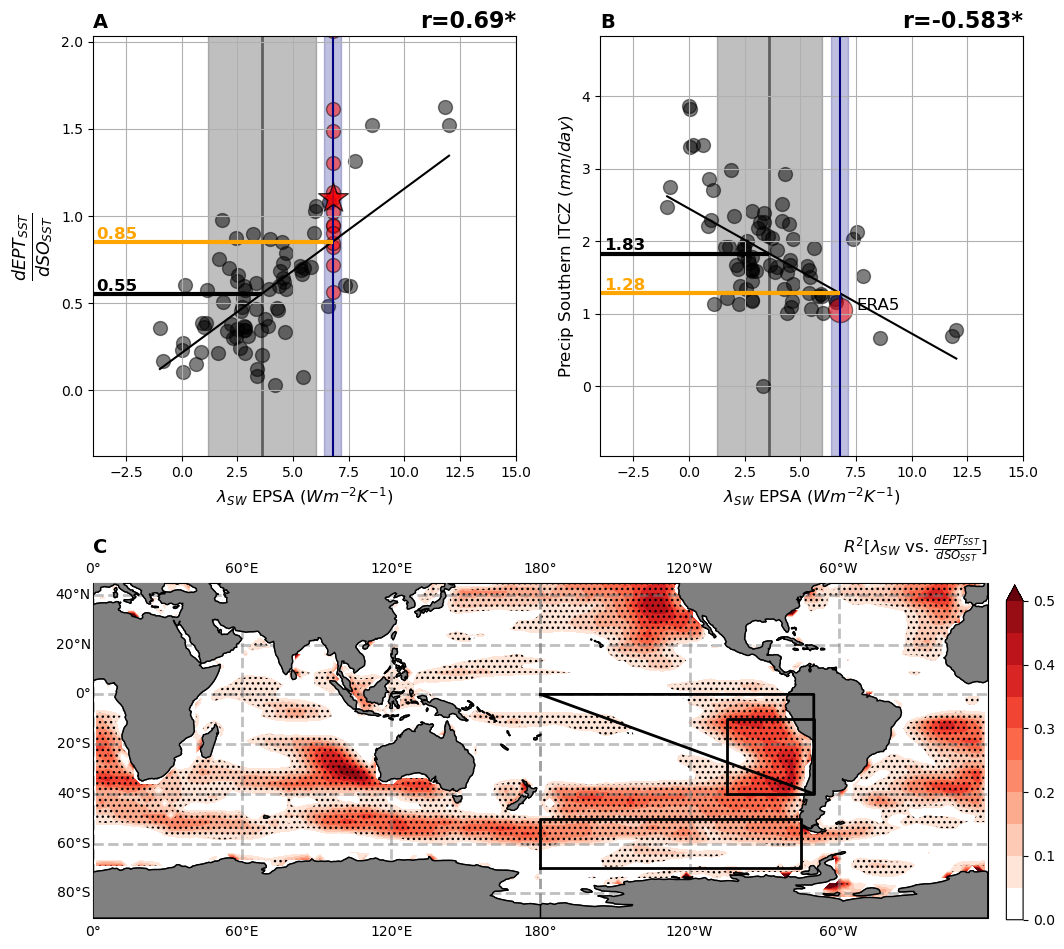

In [13]:
title_fontsize = 14
# Create figure and gridspec
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], wspace=0.2, hspace=0.2)  # 2 rows, 2 columns

# Create scatter plots (top row)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Create map (bottom row, spanning both columns)
ax3 = fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree(central_longitude=180))

######## SWCF EPSA vs dEPT/dSO ############
y, x = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip_epsa)
create_panel_a(ax1, x.values, y.values, vline=obs_swcf)
ax1.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=12)
ax1.set_ylabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=18)
ax1.set_title(r"A", loc="left", fontweight="bold", fontsize=title_fontsize)
ax1.grid()

# Add one dot per obs
obs_mean = []
for model in obs_sst_so_ept_reg.model.values:
    obs_coupling = obs_sst_so_ept_reg.sel(model=model, years=12*5).reg.values
    obs_mean.append(obs_coupling)
    ax1.scatter(np.mean(obs_swcf), obs_coupling, s=100, alpha=.5, edgecolor="black", color="red")
    # ax1.text(s=model, x=np.mean(obs_swcf) + .5, y=obs_coupling, color="black", fontsize=10) # Add text next to point with label
ax1.scatter(np.mean(obs_swcf), np.mean(obs_mean), s=500, zorder=100, alpha=.75, edgecolor="black", color="red", label="Obs Mean", marker="*")

######## SWCF EPSA vs South ITCZ ############
y, x = get_shared_models(cmip_precip_south_east_clim, swcf_cmip_epsa)
create_panel_a(ax2, x.values, y.values, vline=obs_swcf)
ax2.scatter(np.mean(obs_swcf), era5_precip_south_east_clim, s=300, alpha=0.5, edgecolor="black", color="red")
ax2.text(s="ERA5", x=np.mean(obs_swcf) + 0.75, y=era5_precip_south_east_clim, color="black", fontsize=12)
ax2.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=12)
ax2.set_ylabel(r"Precip Southern ITCZ ($mm/day$)", fontsize=12)
ax2.set_title(r"B", loc="left", fontweight="bold", fontsize=title_fontsize)
ax2.grid()

######## SWCF vs dEPT/dSO ############
img = _global_plot(
    ax3,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, 0.55, 0.05),
    cmap="Reds",
)
ax3.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=12)
ax3.set_title(r"C", loc="left", fontweight="bold", fontsize=title_fontsize)
#########################################################################
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_3.png", dpi=300, bbox_inches="tight")
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_3.pdf", dpi=300, bbox_inches="tight")

# Figure SX - Related 5-year SO-EPT to 30-year SO-EPT Coupling

0.559 0.0


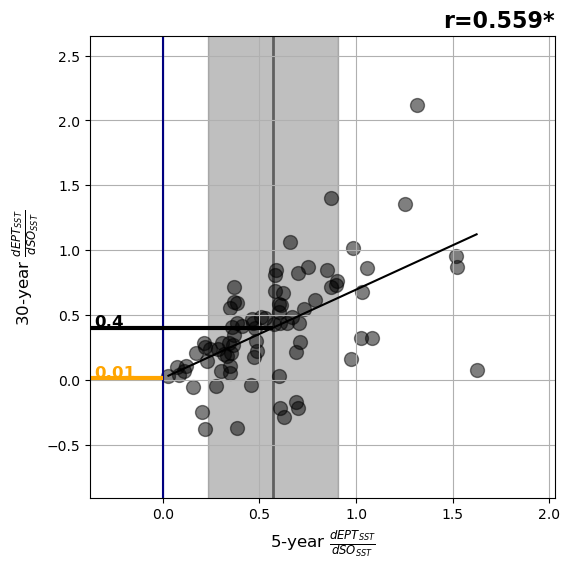

In [15]:
######## SWCF EPSA vs dEPT/dSO ############
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(ax, rvalues_so_ept_coupling["reg"].sel(years=12*5), rvalues_so_ept_coupling["reg"].sel(years=12*30))
ax.set_xlabel(r"5-year $\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=12)
ax.set_ylabel(r"30-year $\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=12)
ax.grid()